### Gymnasium links

Announce: https://farama.org/Announcing-The-Farama-Foundation

Github: https://github.com/Farama-Foundation/Gymnasium

Documentation: https://gymnasium.farama.org/

# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__


In [1]:
# Install gymnasium if you don't have
!pip install gymnasium
!pip install 'gymnasium[toy_text]'

state vector dim = 4
n_actions = 2


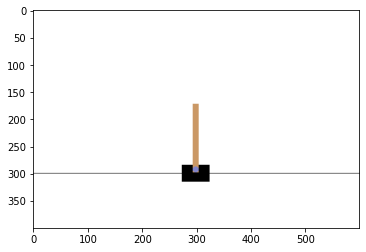

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v1", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [3]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probabilitity of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__

You may also use your favorite neural framework, if it doesn't make it too difficult. The idea is the main thing.

In [4]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [5]:
from tqdm.notebook import tqdm

def generate_session(agent, t_max=1000, test=False):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()


    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        #  s == (1, 4) 1d
        # (n_samples, n_features)
        # (n_features, n_samples)
        probs = agent.predict_proba(s[None, :])[0]

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        if test:
            # on the test use the best (the most likely) actions at test
            # experiment, will it work on the train and vice versa?
            a = np.argmax(probs)
            # ^-- hint: try np.argmax
        else:
            # sample proportionally to the probabilities,
            # don't just take the most likely action at train
            a = np.random.choice(np.arange(n_actions), p=probs)
            # ^-- hint: try np.random.choice
        
        new_s, r, done, info, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.01620753 -0.02680861 -0.03705108 -0.03051647]
 [-0.0167437   0.16882455 -0.03766141 -0.3346553 ]
 [-0.01336721 -0.02574172 -0.04435452 -0.05408271]
 [-0.01388204  0.16998722 -0.04543617 -0.36042333]
 [-0.0104823  -0.02446041 -0.05264464 -0.08240654]]
actions: [1, 0, 1, 0, 0]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

Let's see that it differs from tabular `select_elites`. Our neural network now is trained with one object and it takes an input of `(1, n_states)`. So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

        
    # Let's see that it differs from tabular `select_elites`.
    # Our neural network now is trained with one object and it takes an input of `(1, n_states)`.
    # So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.
    
    states = np.array(states_batch, dtype='object')
    actions = np.array(actions_batch, dtype='object')
    rewards = np.array(rewards_batch, dtype='object')

    reward_threshold = np.percentile(rewards, percentile)
    
    elite_states = []
    elite_actions = []
    for i in np.where(rewards >= reward_threshold)[0]:
        elite_states += states[i]
        elite_actions += actions[i]
        
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [8]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    clear_output(True)
    plt.show()

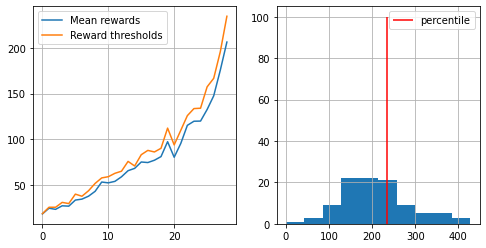

You Win! You may stop training now via KeyboardInterrupt.


In [9]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Results

In [10]:
!pip install imageio_ffmpeg
!pip install moviepy --upgrade


In [11]:
from gymnasium.wrappers.record_video import RecordVideo
env = gym.make('CartPole-v1', render_mode="rgb_array")
env = RecordVideo(env, './videos',  episode_trigger = lambda episode_number: True)

sessions = [generate_session(agent) for _ in range(100)]
env.close()

/Users/takkat14/opt/anaconda3/envs/jupy/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-0.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-1.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-2.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-3.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-4.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-5.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-6.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-7.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-8.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-9.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-10.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-11.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-12.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-13.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-14.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-15.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-16.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-17.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-18.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-19.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-20.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-21.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-22.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-23.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-24.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-25.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-26.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-27.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-28.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-29.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-30.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-31.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-32.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-33.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-34.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-35.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-36.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-37.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-38.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-39.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-40.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-41.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-42.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-43.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-44.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-45.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-46.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-47.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-48.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-49.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-50.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-51.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-52.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-53.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-54.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-55.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-56.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-57.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-58.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-59.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-60.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-61.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-62.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-63.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-64.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-65.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-66.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-67.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-68.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-69.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-70.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-71.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-72.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-73.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-74.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-75.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-76.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-77.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-78.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-79.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-80.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-81.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-82.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-83.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-84.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-85.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-86.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-87.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-88.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-89.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-90.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-91.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-92.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-93.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-94.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-95.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-96.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-97.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-98.mp4
Moviepy - Building video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/takkat14/Documents/Фтиад/RL-course/hw1/videos/rl-video-episode-99.mp4


In [12]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

# Homework

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v1 and feel stuck, feel free to ask us or your peers for help.

### Tasks (up to 1 point each)

* __2.1__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8) or multiprocessing
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips
* Gym page: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

# MountainCar-v0

In [10]:
from joblib import Parallel,  delayed

state vector dim = 2
n_actions = 3


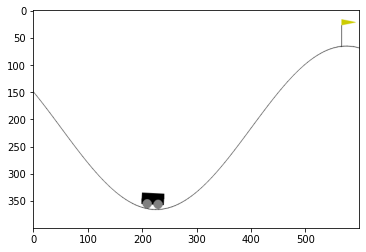

In [11]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [12]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [13]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

        
    # Let's see that it differs from tabular `select_elites`.
    # Our neural network now is trained with one object and it takes an input of `(1, n_states)`.
    # So, we should use `np.squeeze` to remove leading dimension in the deep `select_elites`.
    
    states = np.array(states_batch, dtype='object')
    actions = np.array(actions_batch, dtype='object')
    rewards = np.array(rewards_batch, dtype='object')

    reward_threshold = np.percentile(rewards, percentile)
    
    elite_states = []
    elite_actions = []
    for i in np.where(rewards > reward_threshold)[0]:
        elite_states += states[i]
        elite_actions += actions[i]
        
    return elite_states, elite_actions

In [17]:
%%time
sessions = [generate_session(agent, t_max=10000) for _ in range(n_sessions)]

CPU times: user 1min 25s, sys: 437 ms, total: 1min 25s
Wall time: 1min 25s


In [31]:
def train(agent, n_sessions = 100, percentile = 70, use_joblib=False, last_iter=5):
    """
    Set last_iter = 0 to disable cache
    """
    log = []
    session_cache = []
    for i in range(100):
        n_real_sessions = n_sessions - (i > last_iter) * last_iter 
        
        if not use_joblib:
            sessions = [generate_session(agent, t_max=10000) for _ in tqdm(range(n_real_sessions))]
        else:
            pp = Parallel(n_jobs=-1, backend="threading")
            sessions = pp(delayed(generate_session)(agent, t_max=10000) for _ in tqdm(range(n_real_sessions)))
        
        
        session_cache += sessions
        
        
        if last_iter != 0 and i > last_iter :
            if len(session_cache) > (last_iter - 1) * n_sessions:
                session_cache = session_cache[n_sessions:]
        states_batch, actions_batch, rewards_batch = map(np.array, zip(*session_cache))

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch)

        agent.partial_fit(elite_states, elite_actions)

        show_progress(rewards_batch, log, percentile)

        if np.mean(rewards_batch) > -150:
            print("You Win! You may stop training now via KeyboardInterrupt.")
            break

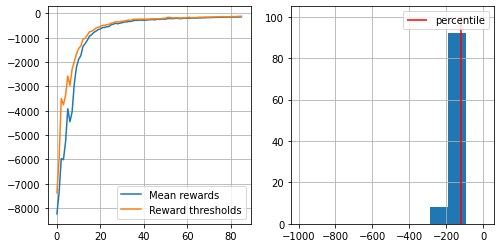

You Win! You may stop training now via KeyboardInterrupt.


In [18]:
from tqdm.notebook import tqdm

n_sessions = 100
percentile = 70
log = []

train()

__Training lasts ~ 14.8 minutes__

### ___Let's optimize___

#### EXP 1: change MLP parameters

In [32]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

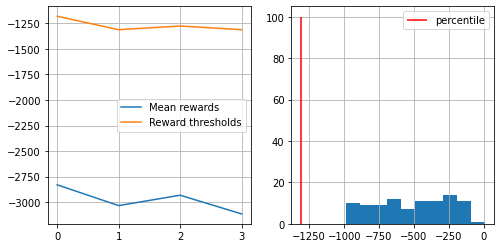

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
%%time
train(agent, use_joblib=True)

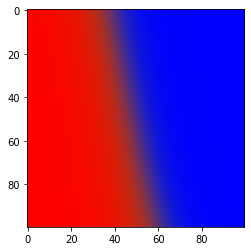

In [19]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

plt.imshow(visualize_mountain_car(env, agent))

### Bonus tasks (up to 0.5 points)

* __2.3 bonus__ Solve continuous action space task with `MLPRegressor` or similar.
  * Start with ["Pendulum-v1"](https://gymnasium.farama.org/environments/classic_control/pendulum/) __(score -150)__.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Solve [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) __(score +90)__ or[LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) __(score -200)__. Slightly less points for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules aside from action spaces.
  * __Please list what you did in anytask submission form__